In [1]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.regularization import *
from lasagne.random import get_rng
from lasagne.updates import *
from lasagne.init import *
import numpy as np
import sys
sys.setrecursionlimit(10000)
sys.path.append("../../modules/")
import helper as hp

from lasagne.utils import floatX

from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

import matplotlib.pyplot as plt
%matplotlib inline

import os
import cPickle as pickle

from theano.tensor import TensorType

from theano.ifelse import ifelse

from time import time

%load_ext rpy2.ipython

from scipy import stats

import deep_residual_learning_CIFAR10

import math

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


We keep all the contents of the tensor with survival probability $p$, so the expectation at test time is also $p$.

In [21]:
class BinomialDropLayer(Layer):
    def __init__(self, incoming, p=0.5, **kwargs):
        super(BinomialDropLayer, self).__init__(incoming, **kwargs)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.p = p

    def get_output_for(self, input, deterministic=False, **kwargs):
        if deterministic:
            return self.p*input
        else:
            #mask = self._srng.binomial(n=1, p=(self.p), size=(input.shape[0],),
            #    dtype=input.dtype)
            # apply the same thing to all examples in the minibatch
            mask = T.zeros((input.shape[0],)) + self._srng.binomial((1,), p=self.p, dtype=input.dtype)[0]
            mask = mask.dimshuffle(0,'x','x','x')
            return mask*input

In [22]:
class IfElseDropLayer(Layer):
    def __init__(self, incoming, p=0.5, **kwargs):
        super(IfElseDropLayer, self).__init__(incoming, **kwargs)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.p = p

    def get_output_for(self, input, deterministic=False, **kwargs):
        if deterministic:
            return self.p*input
        else:
            return ifelse(
                T.lt(self._srng.uniform( (1,), 0, 1)[0], self.p),
                input,
                T.zeros(input.shape)
            )

In [23]:
class SkippableNonlinearityLayer(Layer):
    def __init__(self, incoming, nonlinearity=rectify, p=0.5, **kwargs):
        super(SkippableNonlinearityLayer, self).__init__(incoming, **kwargs)
        self.nonlinearity = (identity if nonlinearity is None
                             else nonlinearity)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.p = p
    def get_output_for(self, input, deterministic=False, **kwargs):
        if deterministic or self.p == 0.0:
            # apply the bernoulli expectation
            return self.p*input + (1-self.p)*self.nonlinearity(input)
        else:
            if input.ndim==4:
                mask = self._srng.binomial(n=1, p=(self.p), size=(input.shape[0],1,1,1),
                    dtype=input.dtype)
                mask = T.addbroadcast(mask, 1,2,3)
                return mask*input + (1-mask)*self.nonlinearity(input)
            elif input.ndim == 2:
                mask = self._srng.binomial(n=1, p=(self.p), size=(input.shape[0],1),
                    dtype=input.dtype)
                mask = T.addbroadcast(mask, 1)
                return mask*input + (1-mask)*self.nonlinearity(input) 

In [24]:
class MoreSkippableNonlinearityLayer(Layer):
    def __init__(self, incoming, nonlinearity=rectify, p=0.5,
                 **kwargs):
        super(MoreSkippableNonlinearityLayer, self).__init__(incoming, **kwargs)
        self.nonlinearity = (identity if nonlinearity is None
                             else nonlinearity)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.p = p

    def get_output_for(self, input, deterministic=False, **kwargs):
        if deterministic or self.p == 0.0:
            # apply the bernoulli expectation
            return self.p*input + (1-self.p)*self.nonlinearity(input)
        else:
            mask = self._srng.binomial(n=1, p=(self.p), size=input.shape,
                dtype=input.dtype)
            return mask*input + (1-mask)*self.nonlinearity(input) 

There is a difference between this residual block method and the one that is defined in [link]. When the number of filters is different to the layer's output shape (or the stride is different), instead of using a convolution to make things compatible, we use an average pooling with a pool size of 1 and a the defined stride, followed by (if necessary) adding extra zero-padded feature maps. This is because this is how the authors in [link] have defined it.

In [39]:
def get_init(name):
    if name == "glorot":
        return GlorotUniform()
    else:
        return HeNormal(gain="relu")

In [5]:
def residual_block(layer, n_out_channels, stride=1, survival_p=None, nonlinearity_p=None, args={}):
    conv = layer
    if stride > 1:
        layer = Pool2DLayer(layer, pool_size=1, stride=stride, mode="average_inc_pad")
    if (n_out_channels != layer.output_shape[1]):
        diff = n_out_channels-layer.output_shape[1]
        if diff % 2 == 0: 
            width_tp = ((diff/2, diff/2),)
        else:
            width_tp = (((diff/2)+1, diff/2),)
        layer = pad(layer, batch_ndim=1, width=width_tp)
    conv = Conv2DLayer(conv, num_filters=n_out_channels,
                       filter_size=(3,3), stride=(stride,stride), pad=(1,1), nonlinearity=linear, W=get_init(args["init"]))
    conv = BatchNormLayer(conv)
    if nonlinearity_p == None:
        conv = NonlinearityLayer(conv, nonlinearity=rectify)
    else:
        conv = MoreSkippableNonlinearityLayer(conv, p=nonlinearity_p, nonlinearity=rectify)
    conv = Conv2DLayer(conv, num_filters=n_out_channels,
                       filter_size=(3,3), stride=(1,1), pad=(1,1), nonlinearity=linear, W=get_init(args["init"]))
    conv = BatchNormLayer(conv)
    if survival_p != None:
        if "use_ifelse_layer" in args:
            sys.stderr.write("using if else drop layer...\n")
            conv = IfElseDropLayer(conv, p=survival_p)
        else:
            conv = BinomialDropLayer(conv, p=survival_p)
    if nonlinearity_p == None:
        return NonlinearityLayer(ElemwiseSumLayer([conv, layer]), nonlinearity=rectify)
    else:
        return MoreSkippableNonlinearityLayer(ElemwiseSumLayer([conv, layer]), nonlinearity=rectify)

In [27]:
def yu_cifar10_net(args):
    # Architecture from:
    # https://github.com/yueatsprograms/Stochastic_Depth/blob/master/main.lua
    N = 18
    survival_p = args["survival_p"]
    nonlinearity_p = args["nonlinearity_p"]
    layer = InputLayer( (None, 3, 32, 32) )
    layer = Conv2DLayer(layer, num_filters=16, filter_size=3, stride=1, pad='same', W=get_init(args["init"]))
    #layer = Pool2DLayer(layer, 2)
    for _ in range(N):
        layer = residual_block(layer, 16, survival_p=survival_p, nonlinearity_p=args["nonlinearity_p"], args=args)
    layer = residual_block(layer, 32, stride=2, survival_p=survival_p, nonlinearity_p=args["nonlinearity_p"], args=args)
    for _ in range(N):
        layer = residual_block(layer, 32, survival_p=survival_p, nonlinearity_p=args["nonlinearity_p"], args=args)
    layer = residual_block(layer, 64, stride=2, survival_p=survival_p, nonlinearity_p=args["nonlinearity_p"], args=args)
    for _ in range(N):
        layer = residual_block(layer, 64, survival_p=survival_p, nonlinearity_p=args["nonlinearity_p"], args=args)
    layer = Pool2DLayer(layer, pool_size=8, stride=1, mode="average_inc_pad")
    layer = DenseLayer(layer, num_units=10, nonlinearity=softmax,
                       W=GlorotUniform() if args["init"] == "glorot" else HeNormal())
    for layer in get_all_layers(layer):
        print layer, layer.output_shape
    print "number of params:", count_params(layer)
    return layer

In [28]:
def linear_decay(l, L, pL=0.5):
    assert l <= L
    l = l*1.0
    L = L*1.0
    return 1.0 - ((l/L)*(1-pL))

In [29]:
def yu_cifar10_net_decay(args):
    # Architecture from:
    # https://github.com/yueatsprograms/Stochastic_Depth/blob/master/main.lua
    
    N = 18
    layer = InputLayer( (None, 3, 32, 32) )
    layer = Conv2DLayer(layer, num_filters=16, filter_size=3, stride=1, pad='same')
    #layer = Pool2DLayer(layer, 2)
    l = 1
    L = 3*N + 2
    for _ in range(N):
        if args["decay"] == "depth":
            layer = residual_block(layer, 16, survival_p=linear_decay(l,L), nonlinearity_p=None, args=args)
        elif args["decay"] == "nonlinearity":
            layer = residual_block(layer, 16, survival_p=None, nonlinearity_p=linear_decay(l,L),args=args)
        elif args["decay"] == "both":
            layer = residual_block(layer, 16, survival_p=linear_decay(l,L), nonlinearity_p=linear_decay(l,L),args=args)
        #print linear_decay(l,L)
        l += 1
    if args["decay"] == "depth":
        layer = residual_block(layer, 32, stride=2, survival_p=linear_decay(l,L), nonlinearity_p=None,args=args)
    elif args["decay"] == "nonlinearity":
        layer = residual_block(layer, 32, stride=2, survival_p=None, nonlinearity_p=linear_decay(l,L),args=args)
    elif args["decay"] == "both":
        layer = residual_block(layer, 32, stride=2, survival_p=linear_decay(l,L), nonlinearity_p=linear_decay(l,L),args=args)
    #print linear_decay(l,L)
    l += 1
    for _ in range(N):
        if args["decay"] == "depth":
            layer = residual_block(layer, 32, survival_p=linear_decay(l,L), nonlinearity_p=None,args=args)
        elif args["decay"] == "nonlinearity":
            layer = residual_block(layer, 32, survival_p=None, nonlinearity_p=linear_decay(l,L), args=args)
        elif args["decay"] == "both":
            layer = residual_block(layer, 32, survival_p=linear_decay(l,L), nonlinearity_p=linear_decay(l,L), args=args)
        #print linear_decay(l,L)
        l += 1
    if args["decay"] == "depth":
        layer = residual_block(layer, 64, stride=2, survival_p=linear_decay(l,L), nonlinearity_p=None, args=args)
    elif args["decay"] == "nonlinearity":
        layer = residual_block(layer, 64, stride=2, survival_p=None, nonlinearity_p=linear_decay(l,L), args=args)
    elif args["decay"] == "both":
        layer = residual_block(layer, 64, stride=2, survival_p=linear_decay(l,L), nonlinearity_p=linear_decay(l,L), args=args)
    #print linear_decay(l,L)
    l += 1
    for _ in range(N):
        if args["decay"] == "depth":
            layer = residual_block(layer, 64, survival_p=linear_decay(l,L), nonlinearity_p=None, args=args)
        elif args["decay"] == "nonlinearity":
            layer = residual_block(layer, 64, survival_p=None, nonlinearity_p=linear_decay(l,L), args=args)
        elif args["decay"] == "both":
            layer = residual_block(layer, 64, survival_p=linear_decay(l,L), nonlinearity_p=linear_decay(l,L), args=args)
        #print linear_decay(l,L)
        l += 1
    #print "l, L =", l, L
    layer = Pool2DLayer(layer, pool_size=8, stride=1, mode="average_inc_pad")
    layer = DenseLayer(layer, num_units=10, nonlinearity=softmax, W=GlorotUniform() if args["init"] == "glorot" else HeNormal())
    for layer in get_all_layers(layer):
        print layer, layer.output_shape
    print "number of params:", count_params(layer)
    return layer

In [30]:
def debug_net(args):
    layer = InputLayer( (None, 3, 32, 32) )
    layer = Conv2DLayer(layer, num_filters=8, filter_size=3)
    layer = MaxPool2DLayer(layer, pool_size=2)
    layer = Conv2DLayer(layer, num_filters=8, filter_size=3)
    layer = MaxPool2DLayer(layer, pool_size=2)
    layer = Conv2DLayer(layer, num_filters=8, filter_size=3)
    layer = MaxPool2DLayer(layer, pool_size=2)
    layer = DenseLayer(layer, nonlinearity=softmax, num_units=10)
    return layer

----

In [11]:
os.path.isfile("cifar10.npz")

False

In [37]:
if os.path.isfile("cifar10.npz"):
    dat = np.load("cifar10.npz")
    X_train, y_train, X_valid, y_valid = dat["X_train"], dat["y_train"], dat["X_valid"], dat["y_valid"]
else:
    sys.stderr.write("loading cifar10 minimal version...\n")
    dat = np.load("/Volumes/CB_RESEARCH/cifar10/cifar10.npz")
    X_train, y_train, X_valid, y_valid = \
        dat["X_train"][0:100], dat["y_train"][0:100], dat["X_valid"][0:100], dat["y_valid"][0:100]

loading cifar10 minimal version...


In [9]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((450, 3, 40, 40), (450,), (50, 3, 32, 32), (50,))

-----

In [31]:
def get_batch_idxs(x, bs):
    b = 0
    arr = []
    while True:
        #print b, x[b*bs : (b+1)*bs].shape
        if x[b*bs : (b+1)*bs].shape[0] != 0:
            arr.append(b)
        else:
            break
        b += 1
    return arr

In [32]:
def get_net(l_out, data, args={}):
    # ----
    X = T.tensor4('X')
    y = T.ivector('y')
    idx = T.lscalar('idx')
    # ----
    net_out = get_output(l_out, X)
    net_out_det = get_output(l_out, X, deterministic=True)
    loss = categorical_crossentropy(net_out, y).mean()
    loss_det = categorical_crossentropy(net_out_det, y).mean()
    if "l2" in args:
        loss += args["l2"]*regularize_layer_params(l_out, l2)
        loss_det += args["l2"]*regularize_layer_params(l_out, l2)
    params = get_all_params(l_out, trainable=True)
    if "max_norm" in args:
        grads = total_norm_constraint( T.grad(loss, params), max_norm=args["max_norm"])
    else:
        grads = T.grad(loss, params)
    learning_rate = theano.shared(floatX(0.01)) if "learning_rate" not in args else \
        theano.shared(floatX(args["learning_rate"]))
    momentum = 0.9 if "momentum" not in args else args["momentum"]
    if "rmsprop" in args:
        sys.stderr.write("using rmsprop instead of nesterov momentum...\n")
        updates = rmsprop(grads, params, learning_rate=learning_rate)
    else:
        updates = nesterov_momentum(grads, params, learning_rate=learning_rate, momentum=momentum)
    # index fns
    bs = args["batch_size"]
    X_train, y_train, X_valid, y_valid = data
    #y_train = T.cast(y_train, "int32")
    #y_valid = T.cast(y_valid, "int32")
    train_fn = theano.function(inputs=[X,y], outputs=loss, updates=updates)
    loss_fn = theano.function(inputs=[X,y], outputs=loss_det)
    preds_fn = theano.function(inputs=[X], outputs=T.argmax(net_out_det,axis=1))
    
    return {
        "train_fn": train_fn,
        "loss_fn": loss_fn,
        "preds_fn": preds_fn,
        "l_out": l_out,
        "learning_rate": learning_rate,
        "bs": bs
    }

In [33]:
def iterate(X_arr, y_arr, bs, augment):
    assert X_arr.shape[0] == y_arr.shape[0]
    b = 0
    while True:
        if b*bs >= X_arr.shape[0]:
            break
        this_X, this_y = X_arr[b*bs:(b+1)*bs], y_arr[b*bs:(b+1)*bs]
        # we need to do this for the training set
        # the valid/test sets are ok
        if augment:
            # ok, we must take a random crop that is 32x32
            new_this_X = []
            for i in range(0, this_X.shape[0]):
                rand_x, rand_y = np.random.randint(0,9), np.random.randint(0,9)
                new_this_X.append(this_X[i, :, rand_x : rand_x+32, rand_y : rand_y+32])
            new_this_X = np.asarray(new_this_X, dtype=this_X.dtype)
            yield new_this_X, this_y
        else:
            yield this_X, this_y
        # ---
        b += 1

In [34]:
def train(net_cfg, 
          num_epochs,
          data,
          out_file=None,
          print_out=True,
          debug=False,
          resume=None,
          schedule={}):
    # prepare the out_file
    l_out = net_cfg["l_out"]
    f = None
    if resume == None:
        if out_file != None:
            f = open("%s.txt" % out_file, "wb")
            f.write("epoch,train_loss,avg_valid_loss,valid_accuracy,time\n")
        if print_out:
            print "epoch,train_loss,avg_valid_loss,valid_accuracy,time"
    else:
        sys.stderr.write("resuming training...\n")
        if out_file != None:
            f = open("%s.txt" % out_file, "ab")
        with open(resume) as g:
            set_all_param_values(l_out, pickle.load(g))          
    # extract functions
    X_train, y_train, X_valid, y_valid = data
    train_fn, loss_fn, preds_fn = net_cfg["train_fn"], net_cfg["loss_fn"], net_cfg["preds_fn"]
    learning_rate = net_cfg["learning_rate"]
    bs = net_cfg["bs"]
    
    # training
    train_idxs = [x for x in range(0, X_train.shape[0])]
    
    if debug:
        sys.stderr.write("idxs: %s\n" % train_idxs)
    for epoch in range(0, num_epochs):
        
        if epoch+1 in schedule:
            sys.stderr.write("changing learning rate to: %f" % schedule[epoch+1])
            learning_rate.set_value( floatX(schedule[epoch+1]) )
        
        np.random.shuffle(train_idxs)
        X_train = X_train[train_idxs]
        y_train = y_train[train_idxs]
        
        # training loop
        this_train_losses = []
        t0 = time()
        for X_train_batch, y_train_batch in iterate(X_train, y_train, bs, True):
            this_train_losses.append( train_fn(X_train_batch, y_train_batch) )
        time_taken = time() - t0
        
        # validation loss loop
        this_valid_losses = []
        for X_valid_batch, y_valid_batch in iterate(X_valid, y_valid, bs, False):
            this_valid_losses.append( loss_fn(X_valid_batch, y_valid_batch) )
        avg_valid_loss = np.mean(this_valid_losses)
        
        # validation accuracy loop
        this_valid_preds = []
        for X_valid_batch, _ in iterate(X_valid, y_valid, bs, False):
            this_valid_preds += preds_fn(X_valid_batch).tolist()
        valid_acc = np.mean( this_valid_preds == y_valid )
        
        ## ------------ ##
        if f != None:
            f.write(
                "%i,%f,%f,%f,%f\n" %
                    (epoch+1, np.mean(this_train_losses), avg_valid_loss, valid_acc, time_taken) 
            )
            f.flush()
        if print_out:
            print "%i,%f,%f,%f,%f" % \
                (epoch+1, np.mean(this_train_losses), avg_valid_loss, valid_acc, time_taken)
        #print valid_loss
        #return train_losses
        
        with open("models/%s.model.%i" % (os.path.basename(out_file),epoch+1), "wb") as g:
            pickle.dump(get_all_param_values(l_out), g, pickle.HIGHEST_PROTOCOL) 
            
    if f != None:
        f.close()

----

Reproduce stochastic depth paper using varying values of $p$ (ie no linear decay).

In [2]:
if "CIFAR10_EXP_1" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0,1,2]:
        for p in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]:
            #old experiments used this
            #np.random.seed(replicate)
            lasagne.random.set_rng(np.random.RandomState(replicate))
            this_args = {}
            out_file = "%s/p%f_stochastic_depth.%i" % (out_folder, p, replicate)
            if os.path.isfile("%s.txt" % out_file):
                continue
            train(
                get_net(
                    yu_cifar10_net({"survival_p": p, "nonlinearity_p": None}),
                    (X_train, y_train, X_valid, y_valid), 
                    {"batch_size": 128}
                ),
                num_epochs=20,
                data=(X_train, y_train, X_valid, y_valid),
                out_file=out_file,
                debug=False
            )

NameError: name 'os' is not defined

Do stochastic nonlinearities.

In [ ]:
if "CIFAR10_EXP_2" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0,1,2]:
        for p in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]:
            lasagne.random.set_rng(np.random.RandomState(replicate))
            this_args = {}
            out_file = "%s/p%f_stochastic_nonlinearity.%i" % (out_folder, p, replicate)
            if os.path.isfile("%s.txt" % out_file):
                continue
            train(
                get_net(
                    yu_cifar10_net({"survival_p": None, "nonlinearity_p": p}),
                    (X_train, y_train, X_valid, y_valid), 
                    {"batch_size": 128}
                ),
                num_epochs=20,
                data=(X_train, y_train, X_valid, y_valid),
                out_file=out_file,
                debug=False
            )

In [19]:
# linear decay schedule for stochastic depth
if "CIFAR10_EXP_3" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0,1,2]:
        #old experiments used this
        #np.random.seed(replicate)
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/stochastic_depth_decay0.5.%i" % (out_folder, replicate)
        if os.path.isfile("%s.txt" % out_file):
            continue
        train(
            get_net(
                yu_cifar10_net_decay({"decay":"depth"}),
                (X_train, y_train, X_valid, y_valid), 
                {"batch_size": 128}
            ),
            num_epochs=40,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False
        )

In [26]:
# linear decay schedule for stochastic nonlinearity
if "CIFAR10_EXP_4" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0,1,2]:
        #old experiments used this
        #np.random.seed(replicate)
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/stochastic_nonlinearity_decay0.5.%i" % (out_folder, replicate)
        if os.path.isfile("%s.txt" % out_file):
            continue
        train(
            get_net(
                yu_cifar10_net_decay({"decay":"nonlinearity"}),
                (X_train, y_train, X_valid, y_valid), 
                {"batch_size": 128}
            ),
            num_epochs=40,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False
        )

In [27]:
# linear decay schedule for stochastic nonlinearity
if "CIFAR10_EXP_5" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0,1,2]:
        #old experiments used this
        #np.random.seed(replicate)
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/stochastic_both_decay0.5.%i" % (out_folder, replicate)
        if os.path.isfile("%s.txt" % out_file):
            continue
        train(
            get_net(
                yu_cifar10_net_decay({"decay":"both"}),
                (X_train, y_train, X_valid, y_valid), 
                {"batch_size": 128}
            ),
            num_epochs=40,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False
        )

----

In [23]:
# long experiment for stochastic depth
if "CIFAR10_EXP_7" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        if "AUGMENT" not in os.environ:
            out_file = "%s/long_stochastic_depth_decay0.5.%i" % (out_folder, replicate)
        else:
            out_file = "%s/long_augment_stochastic_depth_decay0.5.%i" % (out_folder, replicate)
        if os.path.isfile("%s.txt" % out_file):
            continue
        train(
            get_net(
                yu_cifar10_net_decay({"decay":"depth"}),
                (X_train, y_train, X_valid, y_valid), 
                {"batch_size": 128}
            ),
            num_epochs=200,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False
        )

In [24]:
# long experiment for stochastic nonlinearity
if "CIFAR10_EXP_8" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        if "AUGMENT" not in os.environ:
            out_file = "%s/long_stochastic_nonlinearity_decay0.5.%i" % (out_folder, replicate)
        else:
            out_file = "%s/long_augment_stochastic_nonlinearity_decay0.5.%i" % (out_folder, replicate)
        if os.path.isfile("%s.txt" % out_file):
            continue
        train(
            get_net(
                yu_cifar10_net_decay({"decay":"nonlinearity"}),
                (X_train, y_train, X_valid, y_valid), 
                {"batch_size": 128}
            ),
            num_epochs=200,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False
        )

In [27]:
# long experiment for stochastic depth using rmsprop... just curious
if "CIFAR10_EXP_7R" in os.environ and "AUGMENT" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        out_file = "%s/long_augment_rmsprop_stochastic_depth_decay0.5.%i" % (out_folder, replicate)
        if os.path.isfile("%s.txt" % out_file):
            continue
        train(
            get_net(
                yu_cifar10_net_decay({"decay":"depth"}),
                (X_train, y_train, X_valid, y_valid), 
                {"batch_size": 128, "rmsprop": True}
            ),
            num_epochs=1000,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False
        )

In [28]:
# long experiment for stochastic nonlinearity... just curious
if "CIFAR10_EXP_8R" in os.environ and "AUGMENT" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_augment_rmsprop_stochastic_nonlinearity_decay0.5.%i" % (out_folder, replicate)
        if os.path.isfile("%s.txt" % out_file):
            continue
        train(
            get_net(
                yu_cifar10_net_decay({"decay":"nonlinearity"}),
                (X_train, y_train, X_valid, y_valid), 
                {"batch_size": 128, "rmsprop": True}
            ),
            num_epochs=1000,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False
        )

-----

We want to try and reproduce the results as best as possible from: https://github.com/yueatsprograms/Stochastic_Depth/blob/master/main.lua

Need to:

* Use He init (done)
* Use learning rate schedule (had to determine my own)
* Do the random translation crop thing (done)
* Use an L2 weight decay of 1e-4 (done)

In [36]:
if "LONG_BASELINE" in os.environ and "AUGMENT" in os.environ:  
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_baseline_basic_augment.%i" % (out_folder, replicate)
        train(
            get_net(
                yu_cifar10_net({"init":"he", "survival_p":None, "nonlinearity_p": None}),
                (X_train, y_train, X_valid, y_valid), 
                {"batch_size": 128, "l2":1e-4}
            ),
            num_epochs=500,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False,
            schedule={250: 0.001, 375: 0.0001}
        )
# 0.5, 0.75 for cifar10

-----

In [33]:
if "LONG_BASELINE_2" in os.environ:  
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_baseline_more_augment_lr0.1.leto18.%i" % (out_folder, replicate)
        train(
            get_net(
                yu_cifar10_net({"init":"he", "survival_p":None, "nonlinearity_p": None}),
                (X_train, y_train, X_valid, y_valid), 
                {"batch_size": 128, "l2":1e-4, "learning_rate":0.1}
            ),
            num_epochs=500,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False,
            schedule={}
        )

In [1]:
if "LONG_BASELINE_2_RESUME" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_baseline_more_augment_lr0.1_leto18.%i" % (out_folder, replicate)
        train(
            get_net(
                yu_cifar10_net({"init":"he", "survival_p":None, "nonlinearity_p": None}),
                (X_train, y_train, X_valid, y_valid),
                {"batch_size": 128, "l2":1e-4, "learning_rate":0.01}
            ),
            num_epochs=500,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False,
            resume="models/long_baseline_more_augment_lr0.1_leto18.0.model.170.bak"
        )

NameError: name 'os' is not defined

In [ ]:
if "LONG_BASELINE_2_RESUME_2" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_baseline_more_augment_lr0.1_leto18.%i" % (out_folder, replicate)
        train(
            get_net(
                yu_cifar10_net({"init":"he", "survival_p":None, "nonlinearity_p": None}),
                (X_train, y_train, X_valid, y_valid),
                {"batch_size": 128, "l2":1e-4, "learning_rate":0.001}
            ),
            num_epochs=500,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False,
            resume="models/long_baseline_more_augment_lr0.1_leto18.0.model.220.bak2"
        )

In [ ]:
if "LONG_DEPTH" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_depth_more_augment_lr0.1.%i" % (out_folder, replicate)
        train(
            get_net(
                yu_cifar10_net_decay({"init":"he", "decay": "depth"}),
                (X_train, y_train, X_valid, y_valid),
                {"batch_size": 128, "l2":1e-4, "learning_rate":0.1}
            ),
            num_epochs=500,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False,
            schedule={}
        )

In [ ]:
if "LONG_DEPTH_RESUME" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_depth_more_augment_lr0.1.%i" % (out_folder, replicate)
        train(
            get_net(
                yu_cifar10_net_decay({"init":"he", "decay": "depth"}),
                (X_train, y_train, X_valid, y_valid),
                {"batch_size": 128, "l2":1e-4, "learning_rate":0.01}
            ),
            num_epochs=500,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False,
            schedule={},
            resume="models/long_depth_more_augment_lr0.1.0.model.187.bak"
        )

In [ ]:
if "LONG_DEPTH_RESUME_2" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_depth_more_augment_lr0.1.%i" % (out_folder, replicate)
        train(
            get_net(
                yu_cifar10_net_decay({"init":"he", "decay": "depth"}),
                (X_train, y_train, X_valid, y_valid),
                {"batch_size": 128, "l2":1e-4, "learning_rate":0.001}
            ),
            num_epochs=500,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False,
            schedule={},
            resume="models/long_depth_more_augment_lr0.1.0.model.248.bak2"
        )

In [6]:
if "LONG_DEPTH_IFELSE" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_depth_ifelse_more_augment_lr0.1.%i" % (out_folder, replicate)
        train(
            get_net(
                yu_cifar10_net_decay({"init":"he", "decay": "depth", "use_ifelse_layer": True}),
                (X_train, y_train, X_valid, y_valid),
                {"batch_size": 128, "l2":1e-4, "learning_rate":0.1}
            ),
            num_epochs=500,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False,
            schedule={187: 0.01, 248: 0.001}
        )

In [ ]:
if "LONG_NONLINEARITY" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_nonlinearity_more_augment_lr0.1.%i" % (out_folder, replicate)
        train(
            get_net(
                yu_cifar10_net_decay({"init":"he", "decay": "nonlinearity"}),
                (X_train, y_train, X_valid, y_valid),
                {"batch_size": 128, "l2":1e-4, "learning_rate":0.1}
            ),
            num_epochs=500,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False,
            schedule={}
        )

In [ ]:
if "LONG_NONLINEARITY_RESUME" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_nonlinearity_more_augment_lr0.1.%i" % (out_folder, replicate)
        train(
            get_net(
                yu_cifar10_net_decay({"init":"he", "decay": "nonlinearity"}),
                (X_train, y_train, X_valid, y_valid),
                {"batch_size": 128, "l2":1e-4, "learning_rate":0.01}
            ),
            num_epochs=500,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False,
            schedule={},
            resume="models/long_nonlinearity_more_augment_lr0.1.0.model.167.bak"
        )

In [ ]:
if "LONG_NONLINEARITY_RESUME_2" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_nonlinearity_more_augment_lr0.1.%i" % (out_folder, replicate)
        train(
            get_net(
                yu_cifar10_net_decay({"init":"he", "decay": "nonlinearity"}),
                (X_train, y_train, X_valid, y_valid),
                {"batch_size": 128, "l2":1e-4, "learning_rate":0.001}
            ),
            num_epochs=500,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False,
            schedule={},
            resume="models/long_nonlinearity_more_augment_lr0.1.0.model.231.bak2"
        )

In [ ]:
if "LONG_BOTH" in os.environ:
    out_folder = "output_stochastic_depth_resnet_new"
    for replicate in [0]:
        lasagne.random.set_rng(np.random.RandomState(replicate))
        this_args = {}
        out_file = "%s/long_both_more_augment_lr0.1.%i" % (out_folder, replicate)
        train(
            get_net(
                yu_cifar10_net_decay({"init":"he", "decay": "both"}),
                (X_train, y_train, X_valid, y_valid),
                {"batch_size": 128, "l2":1e-4, "learning_rate":0.1}
            ),
            num_epochs=500,
            data=(X_train, y_train, X_valid, y_valid),
            out_file=out_file,
            debug=False,
            schedule={}
        )

-----

Score the test set with the best baseline model

In [13]:
X_test, y_test = dat["X_test"], dat["y_test"]

In [17]:
with open("/Users/cjb60/Dropbox/models/long_baseline_more_augment_lr0.1_leto18.0.model.220.bak2") as f:
    baseline_model = pickle.load(f)

In [41]:
baseline_net = get_net(
    debug_net({"init":"he", "survival_p":None, "nonlinearity_p": None}),
    (X_train, y_train, X_valid, y_valid),
    {"batch_size": 128, "l2":1e-4, "learning_rate":0.1}
)
#set_all_param_values(baseline_net["l_out"], baseline_model)

In [44]:
np.sum( baseline_net["preds_fn"](X_test) == y_test ) / y_test.shape[0]

0

In [45]:
baseline_net["preds_fn"](X_test).shape

(10000,)

## Plot the curves for stochastic depth

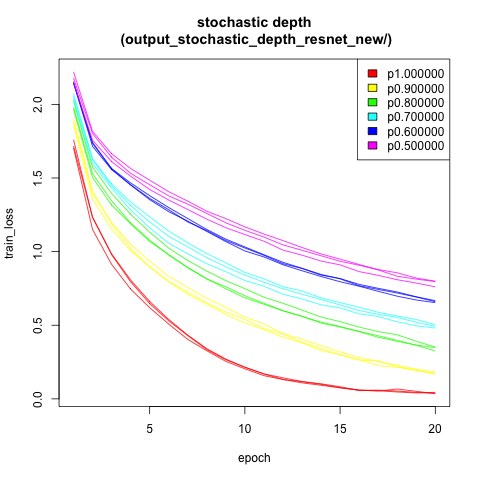

In [11]:
%%R
source("helper.R")

ps = c(
    "p1.000000",
    "p0.900000",
    "p0.800000",
    "p0.700000",
    "p0.600000",
    "p0.500000"
)

plot_results(
    ps, 
    "output_stochastic_depth_resnet_new/", 
    "_stochastic_depth.", 
    "train_loss", 
    "stochastic depth", 
    "topright"
)

Plot the validation curves (non-averaging)

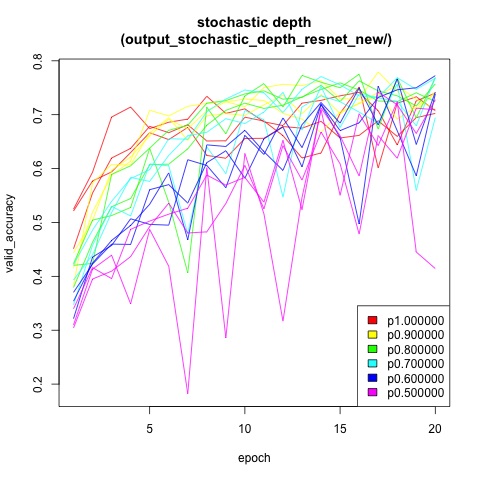

In [12]:
%%R -w 480 -h 480
ps = c(
    "p1.000000",
    "p0.900000",
    "p0.800000",
    "p0.700000",
    "p0.600000",
    "p0.500000"
)

plot_results(
    ps, 
    "output_stochastic_depth_resnet_new/", 
    "_stochastic_depth.", 
    "valid_accuracy", 
    "stochastic depth", 
    "bottomright"
)



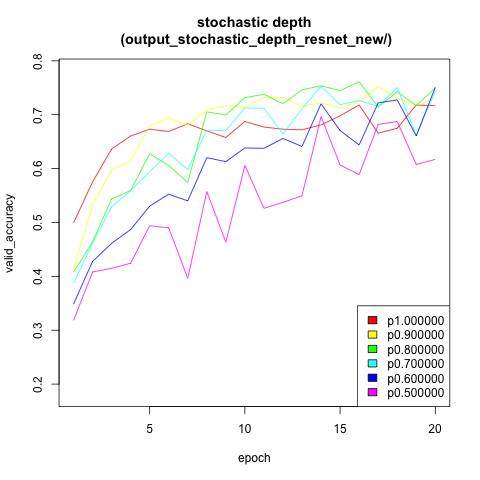

In [14]:
%%R -w 480 -h 480
ps = c(
    "p1.000000",
    "p0.900000",
    "p0.800000",
    "p0.700000",
    "p0.600000",
    "p0.500000"
)

#par(mfrow=c(2,2))

plot_results(
    ps, 
    "output_stochastic_depth_resnet_new/", 
    "_stochastic_depth.", 
    "valid_accuracy", 
    "stochastic depth", 
    "bottomright",
    TRUE
)


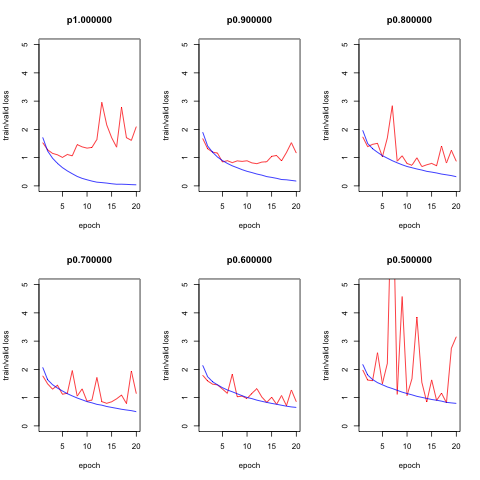

In [29]:
%%R -w 480 -h 480
ps = c(
    "p1.000000",
    "p0.900000",
    "p0.800000",
    "p0.700000",
    "p0.600000",
    "p0.500000"
)

par(mfrow=c(2,3))
out_folder = "output_stochastic_depth_resnet_new/"

for(i in 1:length(ps)) {
    df = read.csv( paste(out_folder, ps[i], "_stochastic_depth.0.txt",sep="") )
    plot(df$avg_valid_loss, type="l", col="red",
         ylim=c(0,5), xlab="epoch", ylab="train/valid loss", main=ps[i])
    lines(df$train_loss, col="blue")
}

## Plot the curves for stochastic nonlinearity

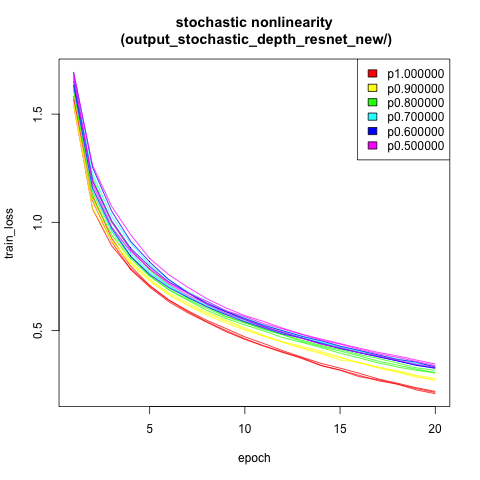

In [15]:
%%R -w 480 -h 480
ps = c(
    "p1.000000",
    "p0.900000",
    "p0.800000",
    "p0.700000",
    "p0.600000",
    "p0.500000"
)

plot_results(
    ps, 
    "output_stochastic_depth_resnet_new/", 
    "_stochastic_nonlinearity.", 
    "train_loss", 
    "stochastic nonlinearity", 
    "topright"
)

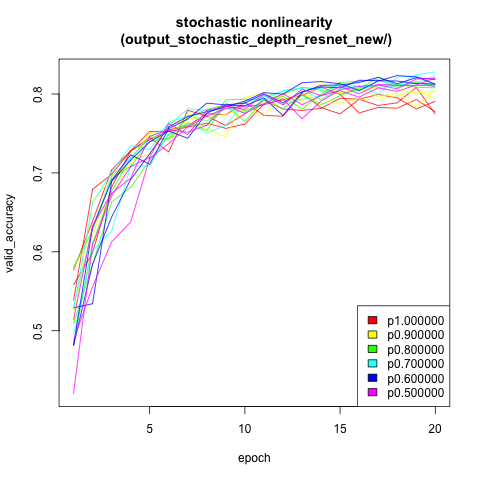

In [17]:
%%R -w 480 -h 480
ps = c(
    "p1.000000",
    "p0.900000",
    "p0.800000",
    "p0.700000",
    "p0.600000",
    "p0.500000"
)

plot_results(
    ps, 
    "output_stochastic_depth_resnet_new/", 
    "_stochastic_nonlinearity.", 
    "valid_accuracy", 
    "stochastic nonlinearity", 
    "bottomright"
)




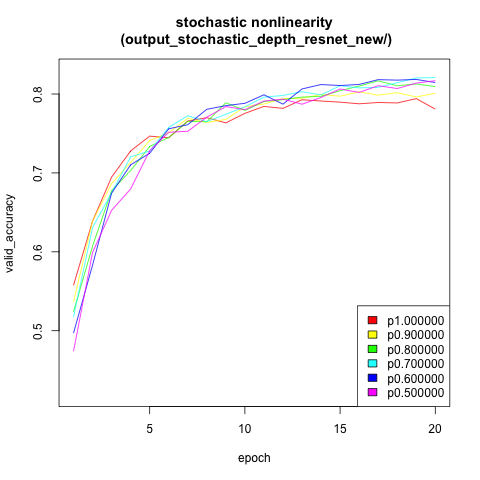

In [18]:
%%R -w 480 -h 480
ps = c(
    "p1.000000",
    "p0.900000",
    "p0.800000",
    "p0.700000",
    "p0.600000",
    "p0.500000"
)

plot_results(
    ps, 
    "output_stochastic_depth_resnet_new/", 
    "_stochastic_nonlinearity.", 
    "valid_accuracy", 
    "stochastic nonlinearity", 
    "bottomright",
    TRUE
)

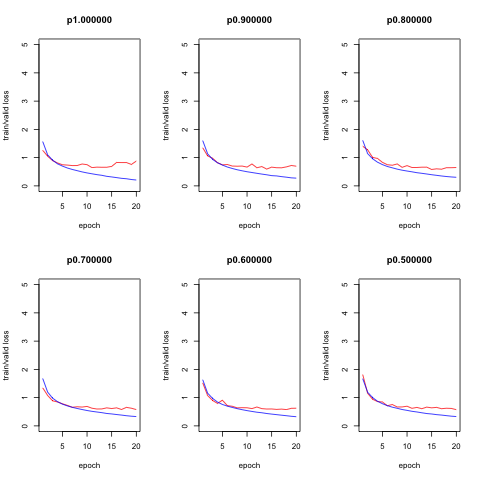

In [30]:
%%R -w 480 -h 480
ps = c(
    "p1.000000",
    "p0.900000",
    "p0.800000",
    "p0.700000",
    "p0.600000",
    "p0.500000"
)

par(mfrow=c(2,3))
out_folder = "output_stochastic_depth_resnet_new/"

for(i in 1:length(ps)) {
    df = read.csv( paste(out_folder, ps[i], "_stochastic_nonlinearity.0.txt",sep="") )
    plot(df$avg_valid_loss, type="l", col="red",
         ylim=c(0,5), xlab="epoch", ylab="train/valid loss", main=ps[i])
    lines(df$train_loss, col="blue")
}

## Plot the curves for stochastic depth with linear decay schedule

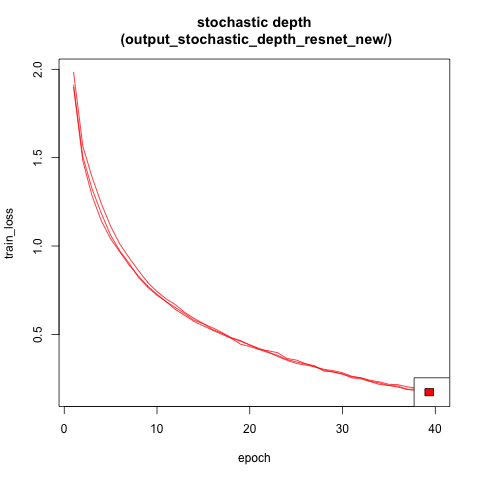

In [22]:
%%R -w 480 -h 480

ps = c("")

plot_results(
    ps, 
    "output_stochastic_depth_resnet_new/", 
    "stochastic_depth_decay0.5.", 
    "train_loss", 
    "stochastic depth", 
    "bottomright"
)

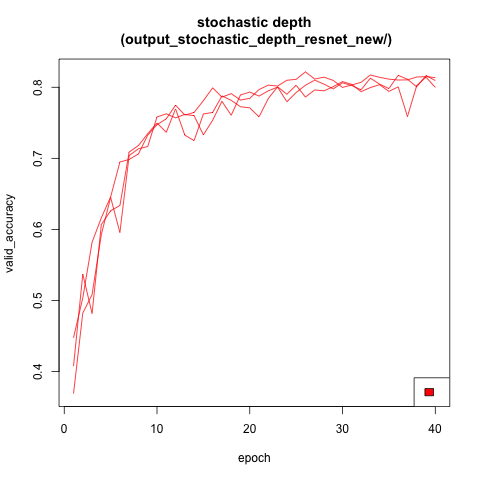

In [23]:
%%R -w 480 -h 480

ps = c("")

plot_results(
    ps, 
    "output_stochastic_depth_resnet_new/", 
    "stochastic_depth_decay0.5.", 
    "valid_accuracy", 
    "stochastic depth", 
    "bottomright"
)

## Plot the curves for stochastic nonlinearity with linear decay schedule

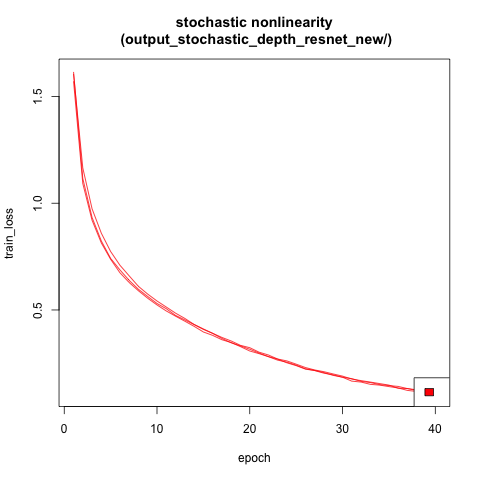

In [24]:
%%R -w 480 -h 480

ps = c("")

plot_results(
    ps, 
    "output_stochastic_depth_resnet_new/", 
    "stochastic_nonlinearity_decay0.5.", 
    "train_loss", 
    "stochastic nonlinearity", 
    "bottomright"
)

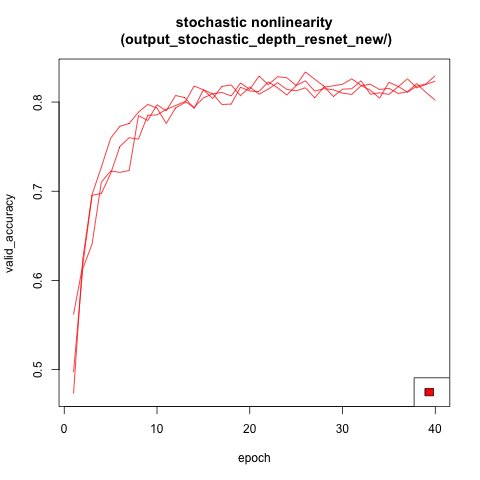

In [25]:
%%R -w 480 -h 480

ps = c("")

plot_results(
    ps, 
    "output_stochastic_depth_resnet_new/", 
    "stochastic_nonlinearity_decay0.5.", 
    "valid_accuracy", 
    "stochastic nonlinearity", 
    "bottomright"
)

## Plot the curves for stochastic depth + nonlinearity with linear decay schedule

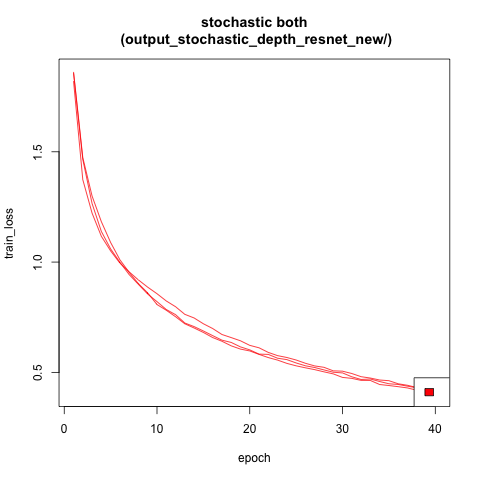

In [26]:
%%R -w 480 -h 480

ps = c("")

plot_results(
    ps, 
    "output_stochastic_depth_resnet_new/", 
    "stochastic_both_decay0.5.", 
    "train_loss", 
    "stochastic both", 
    "bottomright"
)

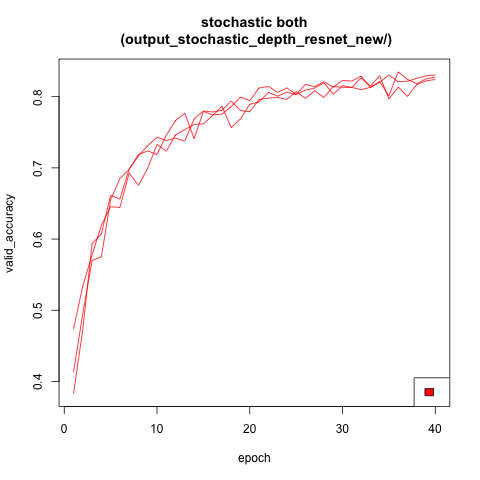

In [27]:
%%R -w 480 -h 480

ps = c("")

plot_results(
    ps, 
    "output_stochastic_depth_resnet_new/", 
    "stochastic_both_decay0.5.", 
    "valid_accuracy", 
    "stochastic both", 
    "bottomright"
)

----

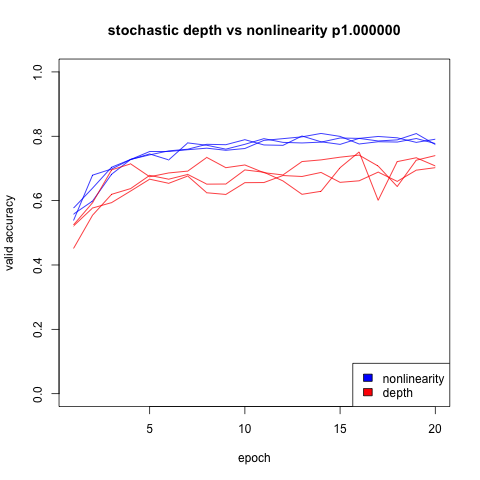

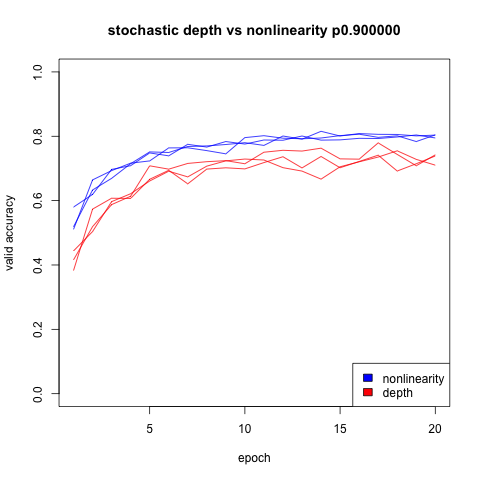

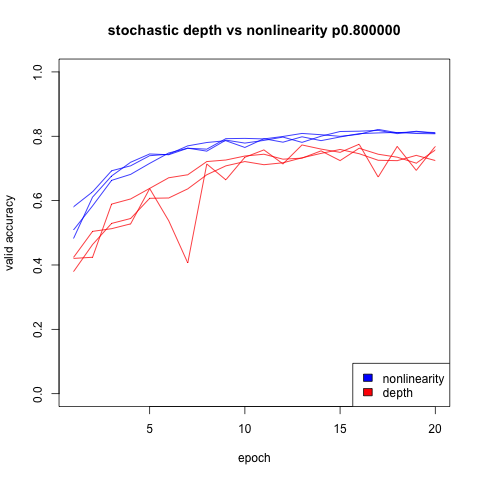

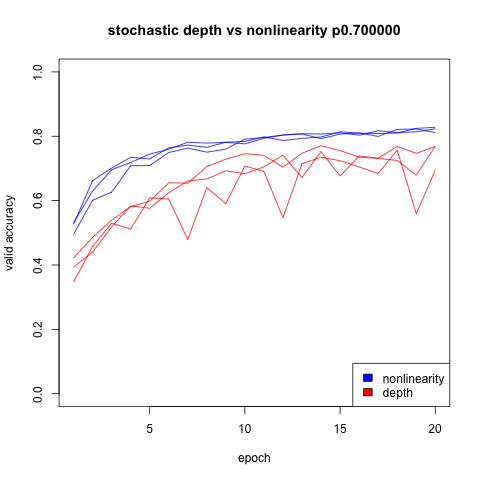

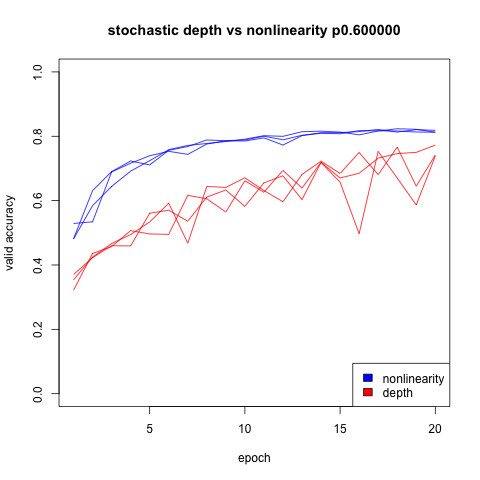

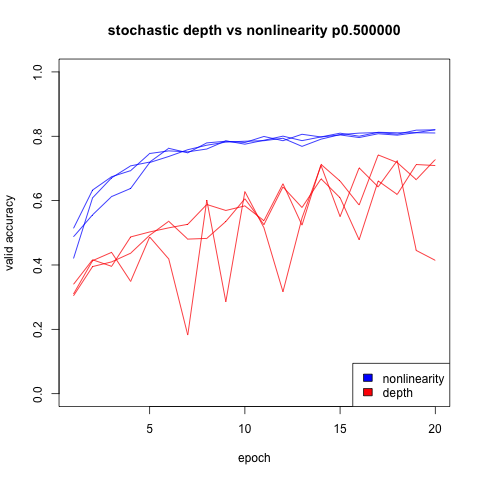

In [31]:
%%R
ps = c(
    "p1.000000",
    "p0.900000",
    "p0.800000",
    "p0.700000",
    "p0.600000",
    "p0.500000"
)
for(i in 1:length(ps)) {
    df_nonlinearity = read.csv(paste("output_stochastic_depth_resnet_new/",ps[i],"_stochastic_nonlinearity.",0,".txt",sep=""))
    df_nonlinearity2 = read.csv(paste("output_stochastic_depth_resnet_new/",ps[i],"_stochastic_nonlinearity.",1,".txt",sep=""))
    df_nonlinearity3 = read.csv(paste("output_stochastic_depth_resnet_new/",ps[i],"_stochastic_nonlinearity.",2,".txt",sep=""))

    df_stochastic = read.csv(paste("output_stochastic_depth_resnet_new/",ps[i],"_stochastic_depth.",0,".txt",sep=""))
    df_stochastic2 = read.csv(paste("output_stochastic_depth_resnet_new/",ps[i],"_stochastic_depth.",1,".txt",sep=""))
    df_stochastic3 = read.csv(paste("output_stochastic_depth_resnet_new/",ps[i],"_stochastic_depth.",2,".txt",sep=""))
    
    # valid loss between both
    plot(df_nonlinearity$valid_accuracy, ylim=c(0,1), type="l", col="blue",
        ylab="valid accuracy", xlab="epoch", main=paste("stochastic depth vs nonlinearity", ps[i]))
    lines(df_nonlinearity2$valid_accuracy, col="blue")
    lines(df_nonlinearity3$valid_accuracy, col="blue")
    
    lines(df_stochastic$valid_accuracy, col="red")
    lines(df_stochastic2$valid_accuracy, col="red")
    lines(df_stochastic3$valid_accuracy, col="red")
    
    legend("bottomright", legend=c("nonlinearity", "depth"), fill=c("blue", "red"))
    
}

In [3]:
%%R -w 900 -h 900

par(mfrow=c(2,2))

plot_lr_lines = function() {
    abline(v=which(df$epoch == 1)[2], col="black", lty="dotted")
    abline(v=which(df$epoch == 1)[3], col="black", lty="dotted")
    abline(v=which(df2$epoch == 1)[2], col="red", lty="dotted")
    abline(v=which(df2$epoch == 1)[3], col="red", lty="dotted")
    abline(v=which(df3$epoch == 1)[2], col="orange", lty="dotted")
    abline(v=which(df3$epoch == 1)[3], col="orange", lty="dotted")
    abline(v=which(df4$epoch == 1)[2], col="green", lty="dotted")
    abline(v=which(df4$epoch == 1)[3], col="green", lty="dotted")    
}

df = read.csv("output_stochastic_depth_resnet_new/long_baseline_more_augment_lr0.1_leto18.0.txt")
df2 = read.csv("output_stochastic_depth_resnet_new/long_depth_more_augment_lr0.1.0.txt")
df3 = read.csv("output_stochastic_depth_resnet_new/long_nonlinearity_more_augment_lr0.1.0.txt")
df4 = read.csv(
    "/Users/cjb60/Desktop/lisa_tmp4_2/msc/experiments/lasagne_additions/output_stochastic_depth_resnet_new/long_both_more_augment_lr0.1.0.txt"
)

labels=c("baseline", "depth", "nonlinearity", "both")
fills=c("black", "red", "orange", "green")

plot(df$train_loss, type="l", ylab="train loss", xlab="epoch")
lines(df2$train_loss, col="red")
lines(df3$train_loss, col="orange")
lines(df4$train_loss, col="green")
plot_lr_lines()
legend("topright", legend=labels, fill=fills)

plot(df$avg_valid_loss, type="l", ylim=c(0,2), ylab="valid loss", xlab="epoch")
lines(df2$avg_valid_loss, col="red")
lines(df3$avg_valid_loss, col="orange")
lines(df4$avg_valid_loss, col="green")
plot_lr_lines()
legend("topright", legend=labels, fill=fills)

plot(df$valid_accuracy, type="l", ylim=c(0,1), ylab="valid accuracy", xlab="epoch")
lines(df2$valid_accuracy, col="red")
lines(df3$valid_accuracy, col="orange")
lines(df4$valid_accuracy, col="green")
plot_lr_lines()
legend("topright", legend=labels, fill=fills)




Error in file(file, "rt") : cannot open the connection


//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in file(file, "rt") : cannot open the connection

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning message:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In file(file, "rt") :
  cannot open file '/Users/cjb60/Desktop/lisa_tmp4_2/msc/experiments/lasagne_additions/output_stochastic_depth_resnet_new/long_both_more_augment_lr0.1.0.txt': No such file or directory

  res = super(Function, self).__call__(*new_args, **new_kwargs)


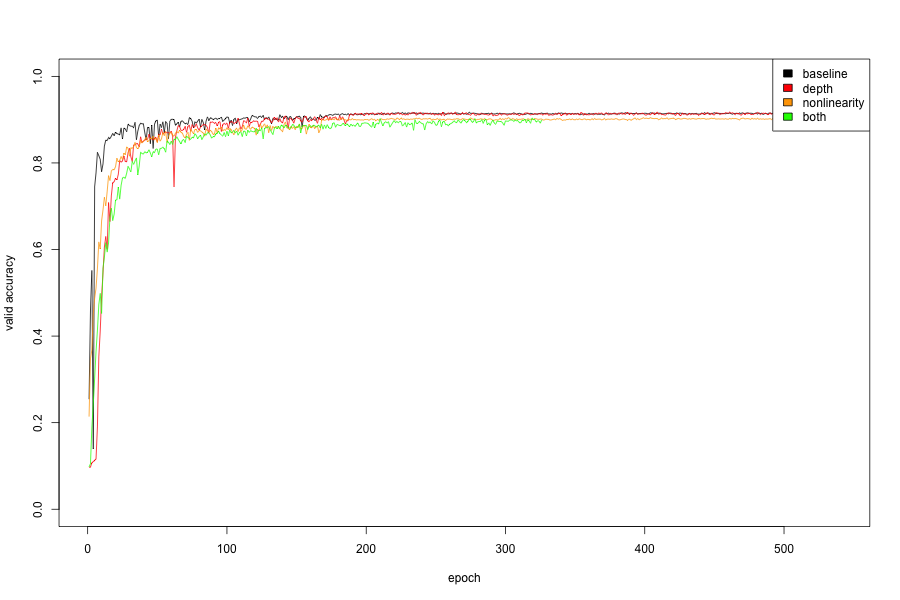

In [2]:
%%R -w 900 -h 600

df = read.csv("output_stochastic_depth_resnet_new/long_baseline_more_augment_lr0.1_leto18.0.txt")
df2 = read.csv("output_stochastic_depth_resnet_new/long_depth_more_augment_lr0.1.0.txt")
df3 = read.csv("output_stochastic_depth_resnet_new/long_nonlinearity_more_augment_lr0.1.0.txt")
df4 = read.csv(
    "/Users/cjb60/Desktop/lisa_tmp4_2/msc/experiments/lasagne_additions/output_stochastic_depth_resnet_new/long_both_more_augment_lr0.1.0.txt"
)

labels=c("baseline", "depth", "nonlinearity", "both")
fills=c("black", "red", "orange", "green")

plot(df$valid_accuracy, type="l", ylim=c(0,1), ylab="valid accuracy", xlab="epoch")
lines(df2$valid_accuracy, col="red")
lines(df3$valid_accuracy, col="orange")
lines(df4$valid_accuracy, col="green")
legend("topright", legend=labels, fill=fills)



----

In [75]:
import draw_net
reload(draw_net)

<module 'draw_net' from 'draw_net.py'>

In [71]:
tmp_net = yu_cifar10_net({"survival_p": 0.5, "nonlinearity_p": 0.0})

<lasagne.layers.input.InputLayer object at 0x1408e1510> (None, 3, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x1408e1690> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x1408e19d0> (None, 16, 32, 32)
<lasagne.layers.normalization.BatchNormLayer object at 0x1408e1a10> (None, 16, 32, 32)
<lasagne.layers.special.NonlinearityLayer object at 0x1408e1c10> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x1408ea090> (None, 16, 32, 32)
<lasagne.layers.normalization.BatchNormLayer object at 0x1408ea050> (None, 16, 32, 32)
<__main__.BinomialDropLayer object at 0x1408ea2d0> (None, 16, 32, 32)
<lasagne.layers.merge.ElemwiseSumLayer object at 0x1408ea6d0> (None, 16, 32, 32)
<lasagne.layers.special.NonlinearityLayer object at 0x1408ea750> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x1408ea790> (None, 16, 32, 32)
<lasagne.layers.normalization.BatchNormLayer object at 0x1408ea7d0> (None, 16, 32, 32)
<lasagne.layers.special.NonlinearityLayer obje

In [79]:
draw_net.draw_to_file(get_all_layers(tmp_net), "network_diagram_stochastic_depth.png")

In [82]:
tmp_net = yu_cifar10_net({"survival_p": 1.0, "nonlinearity_p": 0.5})

<lasagne.layers.input.InputLayer object at 0x119b88210> (None, 3, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x119b88610> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x114b7c090> (None, 16, 32, 32)
<lasagne.layers.normalization.BatchNormLayer object at 0x114b7c0d0> (None, 16, 32, 32)
<__main__.MoreSkippableNonlinearityLayer object at 0x114b7c2d0> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x114b7c6d0> (None, 16, 32, 32)
<lasagne.layers.normalization.BatchNormLayer object at 0x119b88650> (None, 16, 32, 32)
<__main__.BinomialDropLayer object at 0x114b7c910> (None, 16, 32, 32)
<lasagne.layers.merge.ElemwiseSumLayer object at 0x114b7cd10> (None, 16, 32, 32)
<__main__.MoreSkippableNonlinearityLayer object at 0x114b7cd90> (None, 16, 32, 32)
<lasagne.layers.conv.Conv2DLayer object at 0x114b7ce10> (None, 16, 32, 32)
<lasagne.layers.normalization.BatchNormLayer object at 0x114b7ce50> (None, 16, 32, 32)
<__main__.MoreSkippableNonlinearityLayer object 

In [83]:
draw_net.draw_to_file(get_all_layers(tmp_net), "network_diagram_stochastic_nonlinearity.png")

---

In [22]:
lasagne.random.set_rng(np.random.RandomState(1))
l_in = InputLayer( (None, 10) )
l_dense = DenseLayer(l_in, num_units=5)
tmp = theano.function([l_in.input_var], get_output(l_dense, l_in.input_var))

In [23]:
tmp( np.ones((1,10)) )

array([[ 0.18340064,  1.04580887,  0.        ,  0.        ,  0.        ]])